# Baseline Model

Author: Vincent

Last Update: 2024-04-25

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KNeighborsRegressor

In [3]:
import copy
import warnings

In [4]:
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dataset

In [5]:
df_price = pd.read_csv('price_transform.csv')

In [6]:
df_price.head()

,apartment_id,city,exclusive_use_area,floor,latitude,longitude,address_by_law,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,...,heat_type_district,heat_type_-,heat_type_central,heat_type_individual,heat_fuel_gas,heat_fuel_-,heat_fuel_cogeneration,transaction_date_1~10,transaction_date_11~20,transaction_date_21~31
0,5584,1,-1.144215,-0.574122,0.689431,-0.765620,1111017100,-0.747549,-0.926899,-0.839598,...,0,0,0,1,1,0,0,0,1,0
1,5584,1,-1.253498,-0.296118,0.689431,-0.765620,1111017100,-0.747549,-0.926899,-0.839598,...,0,0,0,1,1,0,0,0,1,0
2,5059,1,-0.884577,-0.296118,0.685361,-0.751986,1111017400,-0.249759,-0.528882,-0.553712,...,0,0,0,1,1,0,0,0,1,0
3,2816,1,-0.528869,0.120889,0.685221,-0.754190,1111017400,-0.249759,-0.232807,-0.410768,...,0,0,0,1,1,0,0,0,1,0
4,2816,1,0.969673,-0.435120,0.685221,-0.754190,1111017400,-0.249759,-0.232807,-0.410768,...,0,0,0,1,1,0,0,0,1,0


## Train-test split

In [7]:
_ = df_price[[
    'transaction_real_price',
    'apartment_id',
    'room_id',
    'address_by_law',
    'longitude',
    'latitude'
]]
X_train, X_test, y_train, y_test = train_test_split(_, df_price['transaction_real_price'])

## Baseline Prediction

In [8]:
def regression_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained = explained_variance_score(y_test, y_pred)
    return """mse: %.3f
mae: %.3f
r2: %.3f
explained variance score: %.3f
""" % (mse, mae, r2, explained)

In [9]:
def relative_error_report(y_test, y_pred):
    y_rel_err = (y_pred - y_test) / y_test
    # some predicted as 0 because no data in training set!
    y_rel_err = [e for e in y_rel_err if e != -1 ]
    print('variance: ', np.var(y_rel_err))
    print('mean: ', np.mean(y_rel_err))
    print('max: ', np.max(y_rel_err))
    print('min: ', np.min(y_rel_err))

In [10]:
def bar_relative_error(y_test, y_pred, label=""):
    y_rel_err = (y_pred - y_test) / y_test
    y_rel_err = [e for e in y_rel_err if e != -1 ]
    plt.hist(y_rel_err, bins=100, log=True, histtype='step', label=label)

### Mean Prediction

In [11]:
regressor = DummyRegressor()
regressor.fit(X_train['transaction_real_price'], y_train)
y_pred = regressor.predict(X_test)
print(regression_report(y_test, y_pred))

mse: 104323091252961552.000
mae: 216765632.865
r2: -0.000
explained variance score: 0.000



### Group-By Prediction

In [12]:
class GroupbyRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, feature):
        self.feature = feature
        self.groupby = dict()
    def fit(self, X, y):
        _ = copy.deepcopy(X)
        _['output'] = y
        self.groupby = dict(_.groupby(self.feature)['output'].mean())
    def predict(self, X):
        return X[self.feature].map(lambda i: self.groupby.get(i, 0))

In [13]:
def pseudo_predict(X_test, feature, groupby_dict):
    return X_test[feature].map(lambda i: groupby_dict.get(i, 0))

In [14]:
def groupby_mean_predict_report(X_train, X_test, y_train, y_test, feature):
    regressor = GroupbyRegressor(feature)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print(regression_report(y_test, y_pred))

In [15]:
groupby_mean_predict_report(X_train, X_test, y_train, y_test, 'room_id')

mse: 9212120629048316.000
mae: 58148436.145
r2: 0.912
explained variance score: 0.912



In [16]:
groupby_mean_predict_report(X_train, X_test, y_train, y_test, 'apartment_id')

mse: 19471183724548324.000
mae: 83558476.877
r2: 0.813
explained variance score: 0.813



In [17]:
groupby_mean_predict_report(X_train, X_test, y_train, y_test, 'address_by_law')

mse: 42835600275855528.000
mae: 127502469.359
r2: 0.589
explained variance score: 0.589



**Error Analysis**

===room_id===
variance:  0.07572488980457942
mean:  0.052480512396495864
max:  36.24545454545454
min:  -0.7189655172413794
===apartment_id===
variance:  0.12803114160722726
mean:  0.0887514625664326
max:  22.284199134199135
min:  -0.7608864880794727
===address_by_law===
variance:  0.549353954086828
mean:  0.23116168506203583
max:  38.04666725608004
min:  -0.8699799342105262


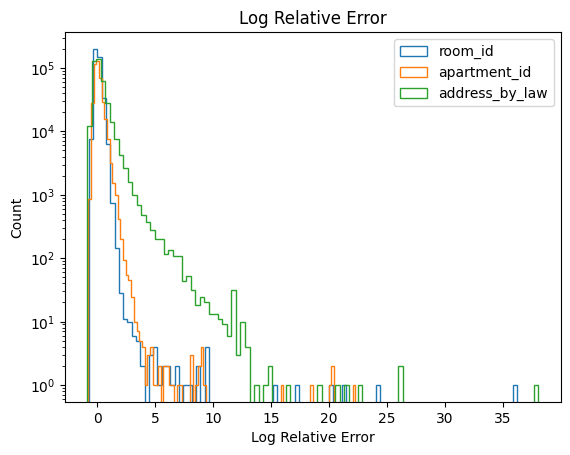

In [18]:
for feature in ['room_id', 'apartment_id','address_by_law']:
    regressor = GroupbyRegressor(feature)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print("===" + feature + "===")
    relative_error_report(y_test, y_pred)
    bar_relative_error(y_test, y_pred, feature)

plt.title('Log Relative Error')
plt.xlabel('Log Relative Error')
plt.ylabel('Count')    
plt.legend()
plt.show()

## Geographical Prediction

In [19]:
knn = KNeighborsRegressor(p=1, n_neighbors=3)

In [20]:
knn.fit(X_train[['longitude', 'latitude']], y_train)
y_pred = knn.predict(X_test[['longitude', 'latitude']])

In [21]:
print(regression_report(y_test, y_pred))

mse: 29572978546275328.000
mae: 97238138.840
r2: 0.717
explained variance score: 0.717



In [22]:
relative_error_report(y_test, y_pred)

variance:  0.16618660356312126
mean:  0.09001602866090774
max:  18.8
min:  -0.8748945147679326


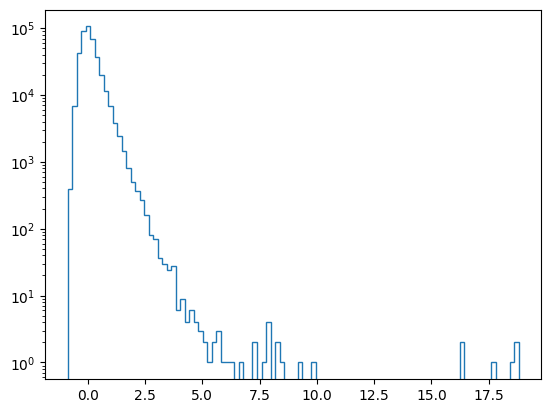

In [23]:
bar_relative_error(y_test, y_pred)
plt.show()

## Linear Combination of Baseline Model

In [24]:
regressor = VotingRegressor([
    ('room', GroupbyRegressor('room_id')), 
    ('knn', KNeighborsRegressor(p=1, n_neighbors=3))
])
y_pred = regressor.fit(X_train, y_train).predict(X_test)

In [25]:
print(regression_report(y_test, y_pred))

mse: 2303444503974866.500
mae: 29075371.565
r2: 0.978
explained variance score: 0.978



In [26]:
relative_error_report(y_test, y_pred)

variance:  0.019189035348117188
mean:  0.025732962617028163
max:  18.077272727272728
min:  -0.503968253968254


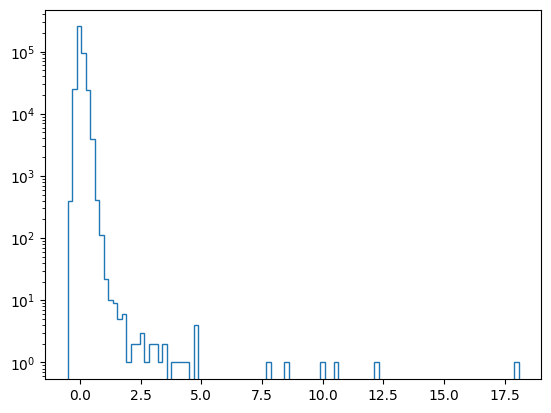

In [27]:
bar_relative_error(y_test, y_pred)
plt.show()

## Conclusion

From the above result, we can see that simply group by `room_id`, `apartment_id` or `address_by_law`, or location-only prediction, already obtain a fairly accurate result.  

Using VotingRegressor, a linear average of the regressor output, combined to cform a astonishing high r2 score.  This further proves that the prediction is not as challenging as we expected.  